In [1]:
!unzip text.zip

Archive:  text.zip
  inflating: text.csv                


In [ ]:
!pip install tensorflow --upgrade


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

LOADING DATASET


In [3]:
df = pd.read_csv('text.csv')


In [4]:
df.head(10)


,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [5]:
df.columns


Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [6]:
# We have droped the extra column
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
# checking the shape
print(f'The Shape Of Data Is : {df.shape}')

The Shape Of Data Is : (416809, 2)


In [8]:
# checking the duplicates we have found some so we are going to remove them
df.duplicated().sum()


686

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()


0

DATA CLEANING


In [10]:
# we need to map the data so we can get the good visualization
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
    # Add more mappings as needed
}

df['label'] = df['label'].map(emotion_map)

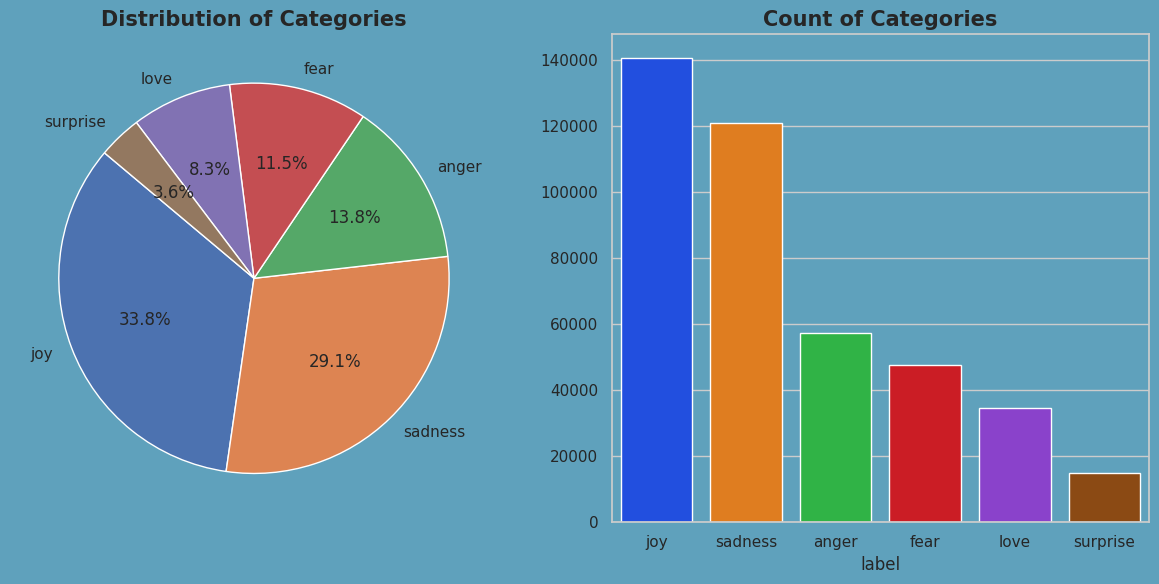

In [11]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

1 | CHAT WORDS

What are the Chat Words?

* Chat words are informal expressions used in online communication, like "lol" and "brb."
* They need to be handled in text processing to normalize and understand them.
* Handling chat words is crucial for accurate analysis, especially in sentiment analysis and chatbot development.
* Preprocessing chat words improves user experience and ensures correct interpretation in conversational interfaces.

In [12]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [13]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)

2 | NON ALPHA NUMERIC CHARACTERS

* Alpha non-numeric values are characters in text data that are not numbers (e.g., letters, symbols).
* Importance of Removing Them:
1.  Data Consistency: Removing alpha non-numeric values ensures that the data is
consistent and follows a standardized format.
2.  Analysis Accuracy: Eliminating these values improves the accuracy of text analysis by focusing on meaningful content.
3.  Model Performance: Models trained on clean data perform better and are less likely to be affected by noise.
4.  Enhanced Readability: Cleaned text is easier to read and understand, which is important for effective communication.

In [14]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


3 | STOP WORDS
* Stop words are common words such as "the," "is," "and," etc., that are often filtered out from text data.


In [15]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


4 | Lowercasing


In [16]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


5 | REMOVING NUMERIC

Removing numbers involves eliminating numerical digits from text data.


In [17]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


6 | REMOVING WHITE SPACE

Removing white spaces involves eliminating extra spaces, tabs, and newline characters from text data.


In [18]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


7 | REMOVING SPECIAL CHARACTER

Special characters are non-alphanumeric characters such as punctuation marks, symbols, and whitespace.

In [19]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


8 | REMOVING URLS

Removing URLs involves eliminating web addresses from text data.


In [20]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


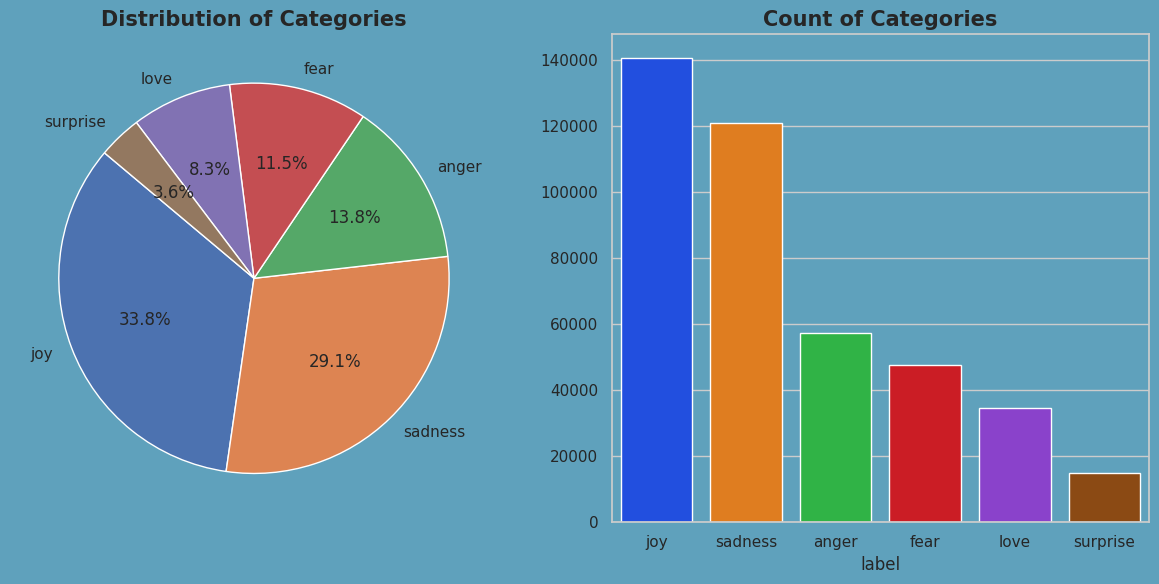

In [21]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
# Define a mapping dictionary
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}

# Rename the 'Label' column using the mapping dictionary
df['label'] = df['label'].map(label_mapping)

In [23]:
df.head()


,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


# Splitting the data

In [24]:
# splitting the data
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

# Train Test Split
#####################################
##### TODO: ADD YOUR CODE HERE  #####
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#####################################

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (332898,)
The shape of X_test is  (83225,)
The shape of y_train is (332898,)
The shape of y_test is (83225,)


Tokenization Trek: Breaking Down the Text!
Introduction to Tokenizer and Sequences¶
* Tokenizer:

  * Tokenizer is a tool used in natural language processing (NLP) to convert text into tokens, which are smaller units like words or subwords.
  * It helps in preprocessing textual data for tasks like text classification, sentiment analysis, and machine translation.
* Why Use Tokenizer:

  * Tokenization is crucial because it breaks down text into manageable pieces for analysis.
  * It standardizes text by converting it into a format that can be easily processed by machine learning algorithms.
* Sequence:

  * In NLP, a sequence refers to an ordered list of tokens representing a piece of text or a sentence.
  * Sequences are fundamental in NLP tasks as they preserve the order of words, which is essential for understanding the meaning of the text.
* Importance of Sequences:

  * Sequences help in capturing the context and relationships between words in a sentence.
  * They enable models to learn from the sequential nature of language, improving performance in tasks like language modeling and text generation.

In [25]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [26]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [27]:
# Maximum Length in X_train_sequences
#####################################
##### TODO: ADD YOUR CODE HERE  #####
maxlen = max(len(seq) for seq in X_train_sequences)

#####################################
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [28]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [29]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [30]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

60000

Building a Bidirectional LSTM Model

1. Define the Model
 initializes a sequential model, where layers are added sequentially.

2. Add an Embedding Layer
 adds an embedding layer. This layer is often used in NLP tasks to convert input text into dense vectors of fixed size. input_dim specifies the size of the vocabulary (e.g., 1000), output_dim is the dimension of the dense embedding, and input_length is the length of input sequences (e.g., 75).

3. Add a Bidirectional GRU Layer
 adds a bidirectional GRU (Gated Recurrent Unit) layer with 128 units. Bidirectional layers process the input sequence in both directions (forward and backward), which can capture more context in the sequence.

4. Add Batch Normalization Layer
 adds a batch normalization layer. Batch normalization normalizes the activations of the previous layer, which can help with training speed and stability.

5. Add Dropout Regularization
 adds a dropout layer with a dropout rate of 0.5. Dropout is a regularization technique that randomly sets a fraction of input units to zero during training, which helps prevent overfitting.

6. Add a Dense Layer with ReLU Activation
 adds a dense layer with 64 units and ReLU activation function. This layer introduces non-linearity into the model.

7. Add Another Dropout Layer
 adds another dropout layer with a dropout rate of 0.5 for further regularization.

8. Add the Output Layer
 adds the output layer with 6 units (assuming a classification task with 6 classes) and softmax activation function. Softmax converts the output into probabilities, where each unit represents the probability of a particular class.

In [33]:
#####################################
##### TODO: ADD YOUR CODE HERE  #####
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, BatchNormalization, Dropout, Dense

# Step 1: Initialize the Model
model = Sequential()

# Step 2: Add the Embedding Layer
model.add(Embedding(input_dim=input_size, output_dim=128, input_length=maxlen))

# Step 3: Add a Bidirectional GRU Layer
model.add(Bidirectional(GRU(units=128, return_sequences=False)))

# Step 4: Add Batch Normalization
model.add(BatchNormalization())

# Step 5: Add Dropout Regularization
model.add(Dropout(0.5))

# Step 6: Add a Dense Layer with ReLU Activation
model.add(Dense(units=64, activation='relu'))

# Step 7: Add Another Dropout Layer
model.add(Dropout(0.5))

# Step 8: Add the Output Layer
# 6 units for classification into 6 emotion categories, with softmax activation for probability outputs.
model.add(Dense(units=6, activation='softmax'))

#####################################

In [43]:
# Compile the model
#####################################
##### TODO: ADD YOUR CODE HERE  #####
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#####################################

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 79, 128)             │       7,680,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,896,006 (30.12 MB)

 Trainable params: 7,895,494 (30.12 MB)

 Non-trainable params: 512 (2.00 KB)

In [38]:
# Model Train
#####################################
##### TODO: ADD YOUR CODE HERE  #####

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("Using GPU for training.")

# One-hot encode the training and testing labels
y_train_onehot = to_categorical(y_train, num_classes=6)
y_test_onehot = to_categorical(y_test, num_classes=6)

# Verify the shapes of the one-hot encoded labels
print("Shape of y_train_onehot:", y_train_onehot.shape)
print("Shape of y_test_onehot:", y_test_onehot.shape)

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
        X_train_padded,             # Padded training data
        y_train_onehot,             # One-hot encoded training labels
        validation_data=(X_test_padded, y_test_onehot),  # Validation data
        epochs=5,                   # Number of epochs
        batch_size=32,              # Batch size
        verbose=1                   # Display progress during training
    )


Num GPUs Available:  1
Using GPU for training.
Shape of y_train_onehot: (332898, 6)
Shape of y_test_onehot: (83225, 6)
Epoch 1/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 172s 17ms/step - accuracy: 0.9334 - loss: 0.1217 - val_accuracy: 0.9367 - val_loss: 0.0975
Epoch 2/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 170s 16ms/step - accuracy: 0.9382 - loss: 0.1051 - val_accuracy: 0.9397 - val_loss: 0.0940
Epoch 3/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - accuracy: 0.9396 - loss: 0.1004 - val_accuracy: 0.9398 - val_loss: 0.0965
Epoch 4/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - accuracy: 0.9405 - loss: 0.0963 - val_accuracy: 0.9407 - val_loss: 0.0952
Epoch 5/5
10404/10404 ━━━━━━━━━━━━━━━━━━━━ 201s 16ms/step - accuracy: 0.9410 - loss: 0.0961 - val_accuracy: 0.9402 - val_loss: 0.0948


Visualizing Training Progress: Accuracy and Loss


The epoch with the highest validation accuracy is: 4


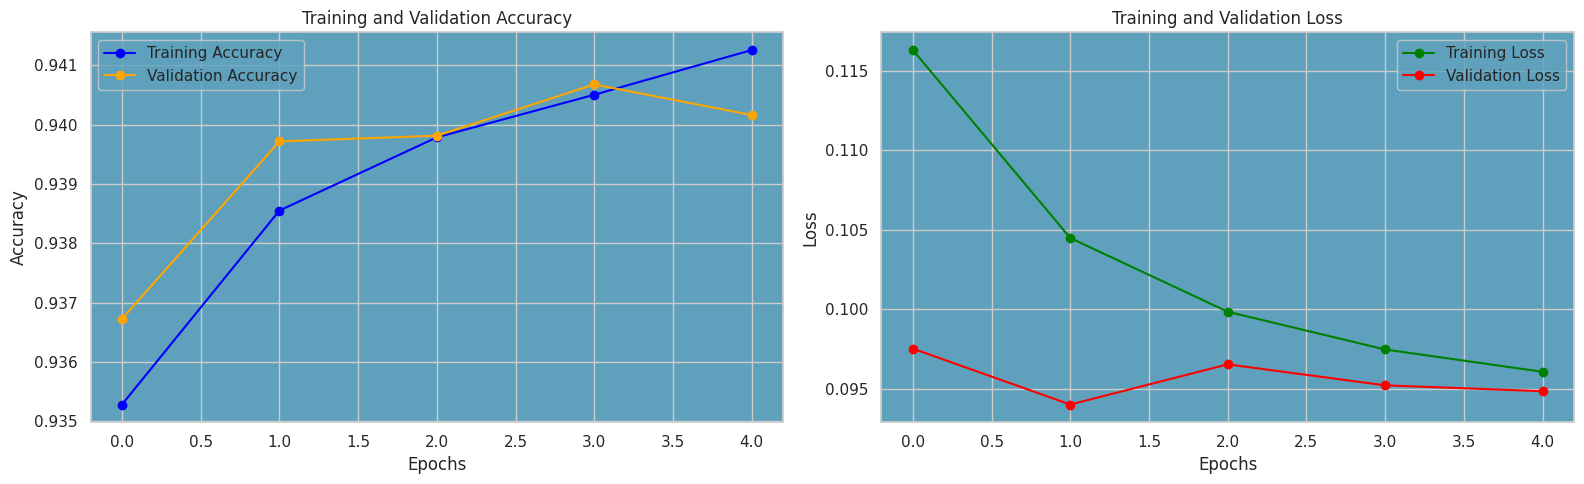

In [39]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
#####################################
##### TODO: ADD YOUR CODE HERE  #####
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
print(f"The epoch with the highest validation accuracy is: {best_epoch}")

#####################################

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
#####################################
##### TODO: ADD YOUR CODE HERE  #####
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)
#####################################

# Plot training and validation loss
#####################################
##### TODO: ADD YOUR CODE HERE  #####
axs[1].plot(history.history['loss'], label='Training Loss', color='green', marker='o')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
#####################################

In [40]:
# Evaluate Test Data
#####################################
##### TODO: ADD YOUR CODE HERE  #####
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_onehot, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

#####################################

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9411 - loss: 0.0934
Test Loss: 0.0948
Test Accuracy: 0.9402


In [41]:
# Predictions On Test For Confustion Matrix
#####################################
##### TODO: ADD YOUR CODE HERE  #####
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the test data
y_pred_prob = model.predict(X_test_padded, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test_onehot, axis=1)  # Convert one-hot labels to class labels

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

#####################################

2601/2601 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


 Confusion Matrix: True vs. Predicted Labels

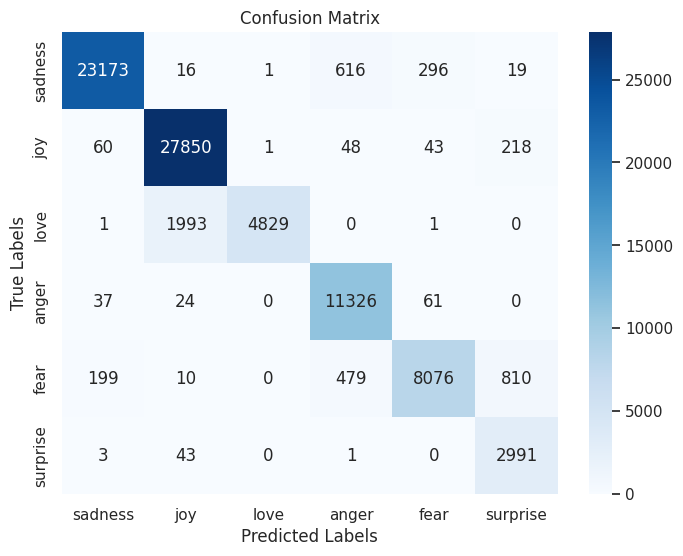

Classification Report:
              precision    recall  f1-score   support

     sadness       0.99      0.96      0.97     24121
         joy       0.93      0.99      0.96     28220
        love       1.00      0.71      0.83      6824
       anger       0.91      0.99      0.95     11448
        fear       0.95      0.84      0.89      9574
    surprise       0.74      0.98      0.85      3038

    accuracy                           0.94     83225
   macro avg       0.92      0.91      0.91     83225
weighted avg       0.95      0.94      0.94     83225



In [42]:
# Plot confusion matrix
#####################################
##### TODO: ADD YOUR CODE HERE  #####
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_map.values(), yticklabels=emotion_map.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print a classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_map.values()))
#####################################